In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

In [2]:
def load_data(data_dir, img_size=(128,128)):
    images = []
    masks = []

    for img_file in os.listdir(data_dir):
        if '_mask' not in img_file:
            img_path = os.path.join(data_dir, img_file)
            mask_path = os.path.join(data_dir, img_file.replace('.jpg', '_mask.jpg'))
    
            img = load_img(img_path, target_size=img_size)
            mask = load_img(mask_path, target_size=img_size, color_mode='grayscale')
    
            img = img_to_array(img) / 255.0
            mask = img_to_array(mask) / 255.0
    
            images.append(img)
            masks.append(mask)

    return np.array(images), np.array(masks)

In [3]:
train_dir = '/kaggle/input/unet1324/split_datasets/train'
val_dir = '/kaggle/input/unet1324/split_datasets/val'
test_dir = '/kaggle/input/unet1324/split_datasets/test'

X_train, y_train = load_data(train_dir)
X_val, y_val = load_data(val_dir)
X_test, y_test = load_data(test_dir)

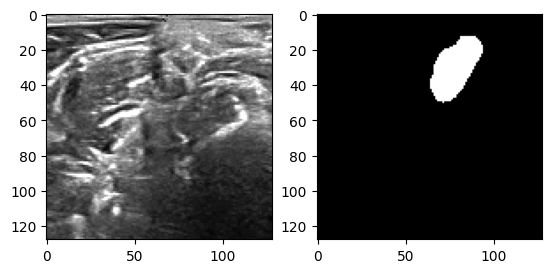

In [4]:
plt.subplot(1, 2, 1)
plt.imshow(X_train[100], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(y_train[100], cmap='gray')

In [5]:
def group_conv2d(inputs, filters, kernel_size, strides=(1, 1), padding='same', groups=1):
    input_channels = inputs.shape[-1]
    if input_channels % groups != 0:
        raise ValueError("입력 채널 수는 그룹 수로 나누어떨어져야 합니다.")

    group_channels = input_channels // groups
    group_list = []

    for i in range(groups):
        group = inputs[..., i * group_channels:(i + 1) * group_channels]
        group_conv = layers.Conv2D(filters // groups, kernel_size, strides=strides, padding=padding)(group)
        group_list.append(group_conv)

    outputs = layers.concatenate(group_list, axis=-1)
    return outputs

def build_grouped_unet(input_shape=(128, 128, 3), groups=None):
    inputs = layers.Input(input_shape)

    # Initial Channels: 3 (input)
    if groups is None:
        groups = 1  # Default group count

    # Down-sampling
    conv1 = group_conv2d(inputs, 32, 3, groups=groups)
    conv1 = group_conv2d(conv1, 32, 3, groups=groups)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    # Adjust group count to match new channel dimensions
    conv2 = group_conv2d(pool1, 64, 3, groups=1)  # Adjust group count to 1
    conv2 = group_conv2d(conv2, 64, 3, groups=1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = group_conv2d(pool2, 128, 3, groups=2)  # Adjust group count to 2
    conv3 = group_conv2d(conv3, 128, 3, groups=2)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = group_conv2d(pool3, 256, 3, groups=4)  # Adjust group count to 4
    conv4 = group_conv2d(conv4, 256, 3, groups=4)

    # Up-sampling
    up7 = layers.concatenate([
        layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv4),
        conv3
    ])
    up7 = layers.Conv2D(128, 1, padding='same')(up7)  # Channel adjustment
    conv7 = group_conv2d(up7, 128, 3, groups=2)  # Adjust group count to 2
    conv7 = group_conv2d(conv7, 128, 3, groups=2)

    up8 = layers.concatenate([
        layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv7),
        conv2
    ])
    up8 = layers.Conv2D(64, 1, padding='same')(up8)  # Channel adjustment
    conv8 = group_conv2d(up8, 64, 3, groups=1)  # Adjust group count to 1
    conv8 = group_conv2d(conv8, 64, 3, groups=1)

    up9 = layers.concatenate([
        layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv8),
        conv1
    ])
    up9 = layers.Conv2D(32, 1, padding='same')(up9)  # Channel adjustment
    conv9 = group_conv2d(up9, 32, 3, groups=1)  # Adjust group count to 1
    conv9 = group_conv2d(conv9, 32, 3, groups=1)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [6]:
model = build_grouped_unet(input_shape=(128, 128, 3), groups=3)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 128, 128, 1)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 128, 128, 1)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 128, 128, 1)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 10)   │            100 │ get_item[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 10)   │            100 │ get_item_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 10)   │            100 │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 128, 30)   │              0 │ conv2d[0][0],          │
│                           │                        │                │ conv2d_1[0][0],        │
│                           │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 128, 128, 10)   │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_4 (GetItem)      │ (None, 128, 128, 10)   │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_5 (GetItem)      │ (None, 128, 128, 10)   │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 10)   │            910 │ get_item_3[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 10)   │            910 │ get_item_4[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 10)   │            910 │ get_item_5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 128, 128, 30)   │              0 │ conv2d_3[0][0],        │
│ (Concatenate)             │                        │                │ conv2d_4[0][0],        │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 30)     │              0 │ concatenate_1[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_6 (GetItem)      │ (None, 64, 64, 30)     │              0 │ max_pooling2d[0][0]    │
├──────────────────────

 Total params: 845,367 (3.22 MB)

 Trainable params: 845,367 (3.22 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    t_true = tf.reduce_sum(y_true)
    y_pred = tf.cast(y_pred > 0.5, dtype=tf.int32)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    intersection = tf.cast(intersection, dtype=tf.float32)

    y_true = tf.reduce_sum(y_true)
    y_pred = tf.reduce_sum(y_pred)

    result = (2.0*(intersection) + smooth) / (y_true + y_pred + smooth)

    return result

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def combined_loss(y_true, y_pred, a=0.95):
    logit_loss_value = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False)

    dice_loss_value = dice_loss(y_true, y_pred)

    return a*dice_loss_value + (1-a)*logit_loss_value

In [8]:
model.compile(optimizer='adam',
             loss = combined_loss,
             metrics=[dice_coef])

In [9]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_dice_coef',
    factor=0.9,
    patience=3,
    min_lr=1e-6,
    mode='max',
    verbose=1
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_unet_model.keras',
    monitor='val_dice_coef',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [10]:
# 모델 학습
history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr, model_checkpoint])

# 모델 저장
model.save('Group_unet_model.keras')

def measure_model_size_and_time(model, sample_input_shape):
    # 모델 사이즈 측정
    model_size = model.count_params()
    model_size_bytes = model_size * 4  # 각 파라미터가 4바이트(32비트)라고 가정

    # 계산 시간 측정
    sample_input = np.random.rand(*sample_input_shape).astype(np.float32)

    start_time = time.time()
    model.predict(sample_input)
    end_time = time.time()

    inference_time = end_time - start_time

    print(f"모델의 파라미터 수: {model_size} (약 {model_size_bytes / (1024 ** 2):.2f} MB)")
    print(f"예측 시간: {inference_time:.4f} 초")

# 사용 예시
measure_model_size_and_time(model, (1, 128, 128, 3))

Epoch 1/50
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - dice_coef: 0.0049 - loss: 0.9594
Epoch 1: val_dice_coef improved from -inf to 0.00000, saving model to best_unet_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 102ms/step - dice_coef: 0.0048 - loss: 0.9592 - val_dice_coef: 1.1786e-10 - val_loss: 0.9587 - learning_rate: 0.0010
Epoch 2/50
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - dice_coef: 8.3740e-04 - loss: 0.9570
Epoch 2: val_dice_coef improved from 0.00000 to 0.00010, saving model to best_unet_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - dice_coef: 9.8073e-04 - loss: 0.9569 - val_dice_coef: 9.9580e-05 - val_loss: 0.9567 - learning_rate: 0.0010
Epoch 3/50
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - dice_coef: 0.0348 - loss: 0.9232
Epoch 3: val_dice_coef improved from 0.00010 to 0.01176, saving model to best_unet_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - dice_coef: 0.0350 - loss: 0.9231 - val_dice_coef: 0.0118 - val_loss: 0.9463 - learning_rate: 0.0010
Epoch 4/50
37/38

NameError: name 'time' is not defined

In [ ]:
best_model = tf.keras.models.load_model('best_unet_model.keras', 
                                       custom_objects={'combined_loss' : combined_loss,
                                                      'dice_coef' : dice_coef})
test_loss, test_dice = best_model.evaluate(X_test, y_test)

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
def visualize_results(model, X, y, num_samples=3):
    predictions = model.predict(X[:num_samples])
    predictions = (predictions > 0.5).astype(np.float32)
    plt.figure(figsize=(4*num_samples, 12))
    for i in range(num_samples):
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(X[i])
        plt.title('Original Image')
        plt.axis('off')
        plt.subplot(3, num_samples, i + 1 + num_samples)
        plt.imshow(y[i, :, :, 0], cmap='gray')
        plt.title(f'True Mask\nDice: {dice_coef(y[i:i+1], predictions[i:i+1]).numpy():.4f}')
        plt.axis('off')
        plt.subplot(3, num_samples, i + 1 + 2*num_samples)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_results(model, X_test, y_test)